In [1]:
import numpy as np
import matplotlib.pyplot as plt

# kinetic parameters with assumed units:
aM = 15.1745   # 1/hr, transcription rate per nM of free DNA: DA--> DA+M
aP = 1         # 1/hr, translation rate per nM of mRNA: M-->M+P
aF = 1         # 1/hr, conversion rate from protein to repressor: P-->P+F
bM = 1         # 1/hr, mRNA degradation rate: M--> ∅
bP = 1         # 1/hr, protein degradation rate : P--> ∅
bF = 1         # 1/hr, repressor degradation rate: F--> ∅
k_f = 200       # 1/(nM·hr), binding rate constant for free DNA and repressor: DA+F--> DR
k_b = 50        # 1/hr, unbinding rate constant for the DNA-repressor complex: DR--> DA+F
DT = 165    # nM, total DNA concentration

In [6]:


# parameters (same units as before)
alpha_M = 15.1745
alpha_P = 1.0
alpha_F = 1.0
beta_M  = 1.0
beta_P  = 1.0
beta_F  = 1.0
Kd = (k_b + beta_F)/k_f
    # kb defined earlier
n_DT    = 165.0
Ω       = 1.0               # volume

Propensities

In [9]:
# ─── Propensity function under tQSSA (Table 3) ─────────────────────────────
def propensity_tqssa(state):
    nM, nP, nR = state
    # φ → M  :  αM/2 * [ nDT - nR - KdΩ + sqrt((nDT - nR - KdΩ)² + 4 nDT KdΩ ) ]
    phi2 = (DT - nR) - Kd*Ω
    sqrt_term = np.sqrt(phi2*phi2 + 4*DT*Kd*Ω)
    rho1 = 0.5*aM*( phi2 + sqrt_term )
    # M → M + P
    rho2 = aP * nM
    # P → P + R
    rho3 = aF * nP
    # M → ∅
    rho4 = bM * nM
    # P → ∅
    rho5 = bP * nP
    # R → ∅
    rho6 = bF * nR
    return np.array([rho1, rho2, rho3, rho4, rho5, rho6])

Gillespie Algorithm

In [10]:
#Stoichiometry updates for each reaction ────────────────────────────────
stoich = np.array([
    [ +1,  0,  0 ],   # R1: φ→M
    [  0, +1,  0 ],   # R2: M→M+P
    [  0,  0, +1 ],   # R3: P→P+R
    [ -1,  0,  0 ],   # R4: M→∅
    [  0, -1,  0 ],   # R5: P→∅
    [  0,  0, -1 ],   # R6: R→∅
])

# ─── Initialize ────────────────────────────────────────────────────────────
t = 0.0
t_max = 40.0
state = np.array([0, 0, 0], dtype=int)  # [nM, nP, nR]
times  = [t]
M_traj = [state[0]]
P_traj = [state[1]]
R_traj = [state[2]]

# ─── Gillespie loop ─────────────────────────────────────────────────────────
while t < t_max:
    rates = propensity_tqssa(state)
    a0 = rates.sum()
    if a0 <= 0:
        break

    # draw next reaction time
    r1 = np.random.rand()
    tau = -np.log(r1) / a0
    t += tau

    # choose which reaction fires next
    r2 = np.random.rand() * a0
    cum = np.cumsum(rates)
    j = np.searchsorted(cum, r2)
    state += stoich[j]

    # record
    times.append(t)
    M_traj.append(state[0])
    P_traj.append(state[1])
    R_traj.append(state[2])

Plots

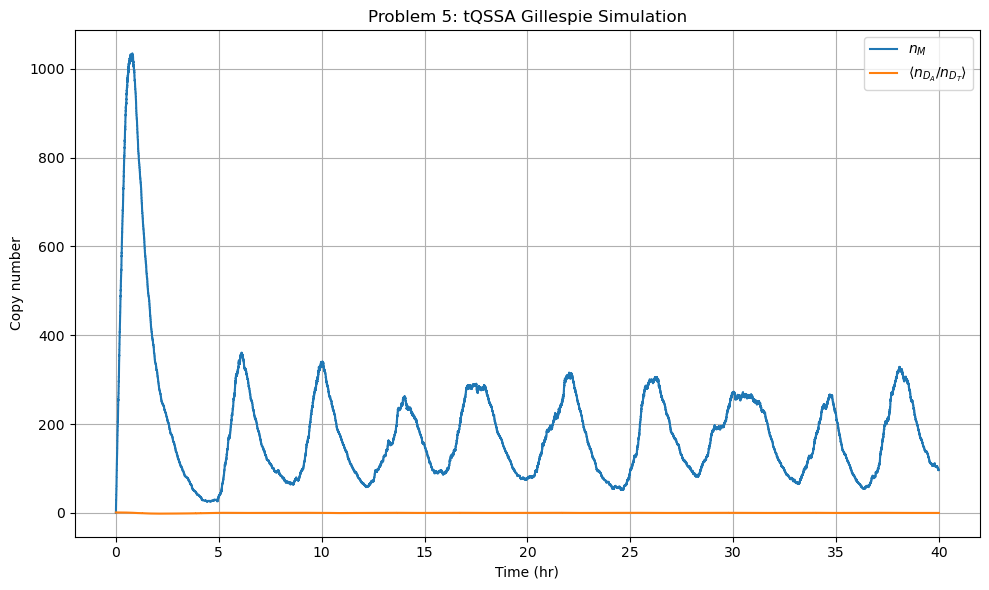

In [11]:
phi_traj = [(DT - r)/DT for r in R_traj]

plt.figure(figsize=(10,6))
plt.step(times, M_traj, where='post', label=r'$n_M$', color='C0')
plt.step(times, phi_traj, where='post', label=r'$\langle n_{D_A}/n_{D_T}\rangle$', color='C1')

plt.xlabel('Time (hr)')
plt.ylabel('Copy number')
plt.title('Problem 5: tQSSA Gillespie Simulation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

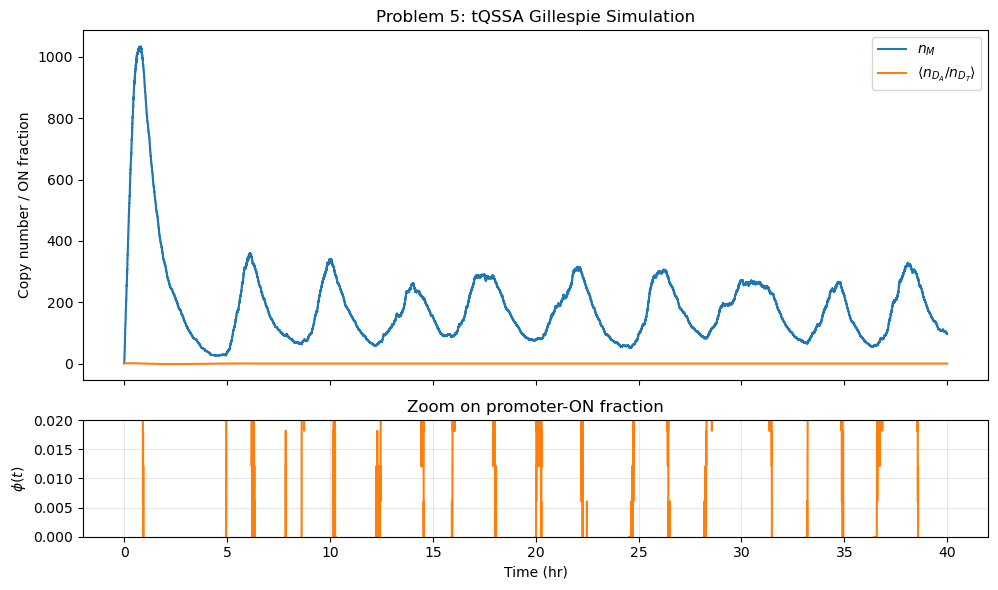

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# … your SSA has produced these lists:
#    times     (list of floats)
#    M_traj    (list of ints)
#    R_traj    (list of ints)
# and you know DT:

phi_traj = [(DT - r)/DT for r in R_traj]

fig, (ax_full, ax_zoom) = plt.subplots(
    2, 1, figsize=(10, 6), sharex=True,
    gridspec_kw={"height_ratios": [3, 1]}
)

# --- full trace ---
ax_full.step(times, M_traj,    where="post", label=r"$n_M$",        color="C0")
ax_full.step(times, phi_traj,  where="post", label=r"$\langle n_{D_A}/n_{D_T}\rangle$", color="C1")
ax_full.set_ylabel("Copy number / ON fraction")
ax_full.legend(loc="upper right")
ax_full.set_title("Problem 5: tQSSA Gillespie Simulation")

# --- zoom on phi only ---
ax_zoom.step(times, phi_traj, where="post", color="C1")
ax_zoom.set_ylim(0, 0.02)            # zoom in on small variations
ax_zoom.set_ylabel(r"$\phi(t)$")
ax_zoom.set_xlabel("Time (hr)")
ax_zoom.set_title("Zoom on promoter-ON fraction")
ax_zoom.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
